## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

## 測試L1參數

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0723 07:40:50.257596  3016 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0723 07:40:50.257596  3016 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 07:40:50.304366  3016 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 07:40:50.304366  3016 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 07:40:50.304366  3016 

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 53us/step - loss: 5.9962 - acc: 0.2771 - val_loss: 5.7965 - val_acc: 0.3492
Epoch 2/50
50000/50000 [==============================] - 2s 47us/step - loss: 5.7066 - acc: 0.3700 - val_loss: 5.6234 - val_acc: 0.3882
Epoch 3/50
50000/50000 [==============================] - 2s 47us/step - loss: 5.5607 - acc: 0.3995 - val_loss: 5.4950 - val_acc: 0.4086
Epoch 4/50
50000/50000 [==============================] - 2s 49us/step - loss: 5.4405 - acc: 0.4184 - val_loss: 5.3813 - val_acc: 0.4336
Epoch 5/50
50000/50000 [==============================] - 2s 47us/step - loss: 5.3336 - acc: 0.4353 - val_loss: 5.2954 - val_acc: 0.4351
Epoch 6/50
50000/50000 [==============================] - 2s 47us/step - loss: 5.2345 - acc: 0.4489 - val_loss: 5.1983 - val_acc: 0.4460
Epoch 7/50
50000/50000 [==============================] - 2s 47us/step - loss: 5.1412 - acc: 0.4583 - val_loss: 5.1138 - val_acc

50000/50000 [==============================] - 2s 47us/step - loss: 1.7965 - acc: 0.3682 - val_loss: 1.7480 - val_acc: 0.3837
Epoch 3/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.7164 - acc: 0.3978 - val_loss: 1.6839 - val_acc: 0.4091
Epoch 4/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.6622 - acc: 0.4201 - val_loss: 1.6435 - val_acc: 0.4176
Epoch 5/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.6179 - acc: 0.4346 - val_loss: 1.6120 - val_acc: 0.4312
Epoch 6/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5800 - acc: 0.4472 - val_loss: 1.5830 - val_acc: 0.4419
Epoch 7/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.5471 - acc: 0.4580 - val_loss: 1.5474 - val_acc: 0.4531
Epoch 8/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.5194 - acc: 0.4684 - val_loss: 1.5274 - val_acc: 0.4569
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 2s 47us/step - loss: 1.7179 - acc: 0.3975 - val_loss: 1.6905 - val_acc: 0.4112
Epoch 4/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.6594 - acc: 0.4188 - val_loss: 1.6335 - val_acc: 0.4326
Epoch 5/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.6139 - acc: 0.4320 - val_loss: 1.6036 - val_acc: 0.4355
Epoch 6/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.5746 - acc: 0.4494 - val_loss: 1.5729 - val_acc: 0.4441
Epoch 7/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.5420 - acc: 0.4610 - val_loss: 1.5390 - val_acc: 0.4579
Epoch 8/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5101 - acc: 0.4710 - val_loss: 1.5228 - val_acc: 0.4679
Epoch 9/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.4846 - acc: 0.4790 - val_loss: 1.5003 - val_acc: 0.4709
Epoch 10/50
50000/50000 [===========================

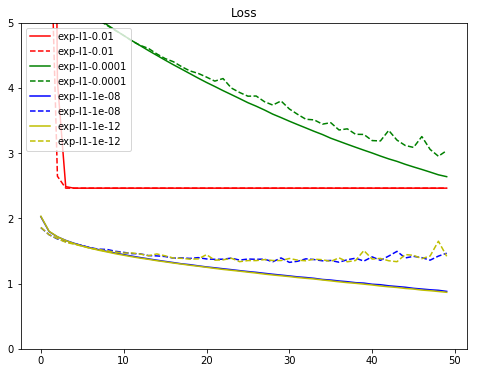

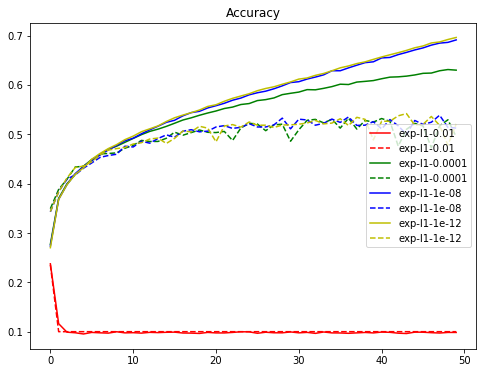

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## 測試L1_L2參數

In [9]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1_L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], L1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(L1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(L1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]


In [11]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6s" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], L1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1_l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=========================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 59us/step - loss: 18.7982 - acc: 0.2754 - val_loss: 17.3526 - val_acc: 0.3431
Epoch 2/50
50000/50000 [==============================] - 2s 49us/step - loss: 16.1404 - acc: 0.3575 - val_loss: 14.9816 - val_acc: 0.3707
Epoch 3/50
50000/50000 [==============================] - 2s 49us/step - loss: 13.9548 - acc: 0.3793 - val_loss: 12.9734 - val_acc: 0.3826
Epoch 4/50
50000/50000 [==============================] - 3s 52us/step - loss: 12.1056 - acc: 0.3945 - val_loss: 11.2694 - val_acc: 0.3960
Epoch 5/50
50000/50000 [==============================] - 3s 51us/step - loss: 10.5335 - acc: 0.4022 - val_loss: 9.8296 - val_acc: 0.4047
Epoch 6/50
50000/50000 [==============================] - 3s 52us/step - loss: 9.1976 - acc: 0.4096 - val_loss: 8.5877 - val_acc: 0.4163
Epoch 7/50
50000/50000 [==============================] - 2s 49us/step - loss: 8.0590 - acc: 0.4158 - val_loss: 7.5441 

50000/50000 [==============================] - 2s 49us/step - loss: 13.0031 - acc: 0.3581 - val_loss: 12.1192 - val_acc: 0.3613
Epoch 3/50
50000/50000 [==============================] - 2s 49us/step - loss: 11.3328 - acc: 0.3795 - val_loss: 10.5823 - val_acc: 0.3936
Epoch 4/50
50000/50000 [==============================] - 3s 52us/step - loss: 9.9226 - acc: 0.3951 - val_loss: 9.2920 - val_acc: 0.3962
Epoch 5/50
50000/50000 [==============================] - 2s 49us/step - loss: 8.7246 - acc: 0.4059 - val_loss: 8.1799 - val_acc: 0.4159
Epoch 6/50
50000/50000 [==============================] - 2s 49us/step - loss: 7.7034 - acc: 0.4119 - val_loss: 7.2471 - val_acc: 0.4105
Epoch 7/50
50000/50000 [==============================] - 2s 49us/step - loss: 6.8337 - acc: 0.4193 - val_loss: 6.4394 - val_acc: 0.4202
Epoch 8/50
50000/50000 [==============================] - 3s 50us/step - loss: 6.0902 - acc: 0.4259 - val_loss: 5.7580 - val_acc: 0.4239
Epoch 9/50
50000/50000 [========================

50000/50000 [==============================] - 3s 50us/step - loss: 11.3514 - acc: 0.3799 - val_loss: 10.5990 - val_acc: 0.3899
Epoch 4/50
50000/50000 [==============================] - 2s 47us/step - loss: 9.9384 - acc: 0.3939 - val_loss: 9.2940 - val_acc: 0.4026
Epoch 5/50
50000/50000 [==============================] - 2s 47us/step - loss: 8.7371 - acc: 0.4046 - val_loss: 8.2056 - val_acc: 0.4014
Epoch 6/50
50000/50000 [==============================] - 2s 47us/step - loss: 7.7148 - acc: 0.4134 - val_loss: 7.2522 - val_acc: 0.4149
Epoch 7/50
50000/50000 [==============================] - 2s 47us/step - loss: 6.8411 - acc: 0.4209 - val_loss: 6.4489 - val_acc: 0.4223
Epoch 8/50
50000/50000 [==============================] - 2s 47us/step - loss: 6.0977 - acc: 0.4258 - val_loss: 5.7587 - val_acc: 0.4273
Epoch 9/50
50000/50000 [==============================] - 2s 47us/step - loss: 5.4605 - acc: 0.4328 - val_loss: 5.1826 - val_acc: 0.4247
Epoch 10/50
50000/50000 [=========================

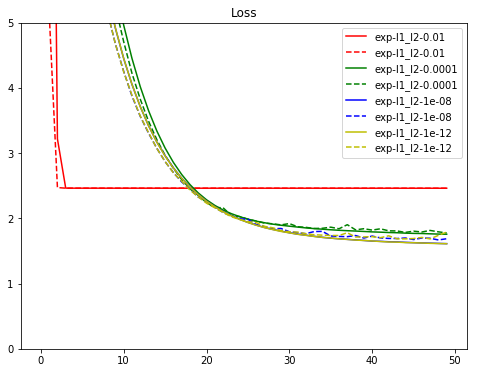

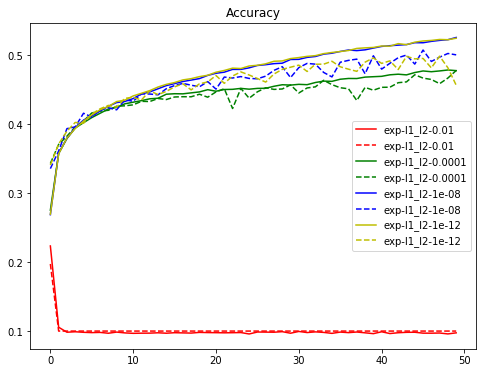

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()